<h2>06 피마 인디언 당뇨병 예측</h2>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('D:/WE_IT/doit/파이썬머신러닝완벽가이드/data/diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

Outcome
0    500
1    268
Name: count, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


출력결과 Negative 값 0이 500개, Positive 값 1이 268개로 Negative가 상대적으로 많음.

In [2]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


출력 결과 Null 값은 없으면 피처의 타입은 모두 숫자형임. 따라서 별도의 피처 인코딩은 필요하지 않아 보임.

<h4>[앞 예제들에서 사용한 유틸리티 함수들]</h4>

In [3]:
# 수정된 get_clf_eval() 함수 
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [4]:
def precision_recall_curve_plot(y_test=None, pred_proba_c1=None):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

In [12]:
from sklearn.preprocessing import Binarizer

def get_eval_by_threshold(y_test , pred_proba_c1, thresholds):
    # thresholds 리스트 객체내의 값을 차례로 iteration하면서 Evaluation 수행.
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1) 
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:',custom_threshold)
        get_clf_eval(y_test , custom_predict, pred_proba_c1)

<h4>[로지스틱 회귀를 이용해 예측 모델을 생성]</h4>

In [5]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출. 
# 맨 끝이 Outcome 컬럼으로 레이블 값임. 컬럼 위치 -1을 이용해 추출 
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습,예측 및 평가 수행. 
lr_clf = LogisticRegression(solver='liblinear')
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926,    F1: 0.6465, AUC:0.8083


위에서 Negative값이 전체 데이터의 65%임을 확인했었으므로, 정확도 보다는 재현율 성능에 조금 더 초점을 맞춰 보기.

<h4>[정밀도 재현율 곡선을 보고 임곗값별 정밀도와 재현율 값의 변화를 확인]</h4>

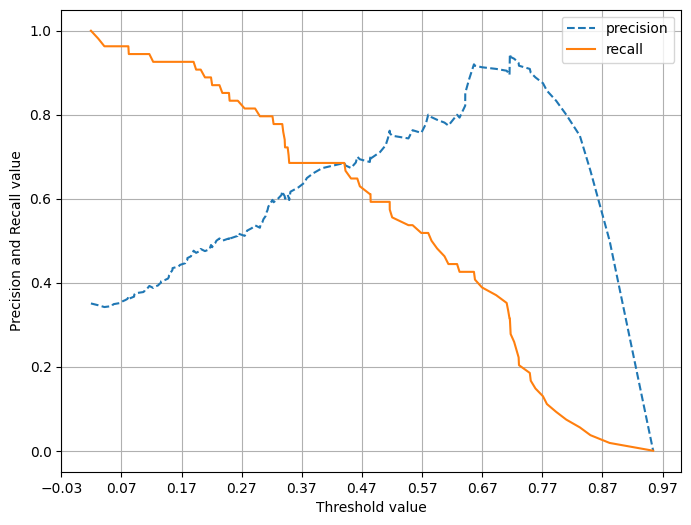

In [6]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)

출력결과 임곗값을 0.42정도로 낮추면 정밀도와 재현율이 균형을 맞추지만, 두 개의 지표 모두 0.7이 안되는 수치로 낮음.
<br>따라서 임곗값을 인위적으로 조작하기 전에 다시 데이터 값 점검

In [7]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


출력 결과 min 값이 0으로 되어있는 피처가 상당히 많음.
<br>예를 들어, Glucose 피처는 포도당 수치인데 min 값이 0일수가 없음.

(array([ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  3.,  0.,  1.,  1.,  1.,  1.,  3.,  4.,  4.,  6.,  4.,
         7., 12.,  9., 17., 10., 15., 20., 16., 20., 17., 20., 26., 22.,
        19., 25., 25., 20., 18., 21., 18., 17., 17., 21., 25., 14., 25.,
        12., 10., 10., 16., 13., 10., 11., 12., 16.,  5.,  9.,  6., 11.,
         5., 10.,  4.,  9.,  7.,  6.,  5.,  5.,  7.,  4.,  3.,  6., 10.,
         4.,  3.,  5.,  6.,  2.,  2.,  5.,  7.,  2.]),
 array([  0.  ,   1.99,   3.98,   5.97,   7.96,   9.95,  11.94,  13.93,
         15.92,  17.91,  19.9 ,  21.89,  23.88,  25.87,  27.86,  29.85,
         31.84,  33.83,  35.82,  37.81,  39.8 ,  41.79,  43.78,  45.77,
         47.76,  49.75,  51.74,  53.73,  55.72,  57.71,  59.7 ,  61.69,
         63.68,  65.67,  67.66,  69.65,  71.64,  73.63,  75.62,  77.61,
         79.6 ,  81.59,  83.58,  85.57,  87.56,  89.55,  91.54,  93.53,
  

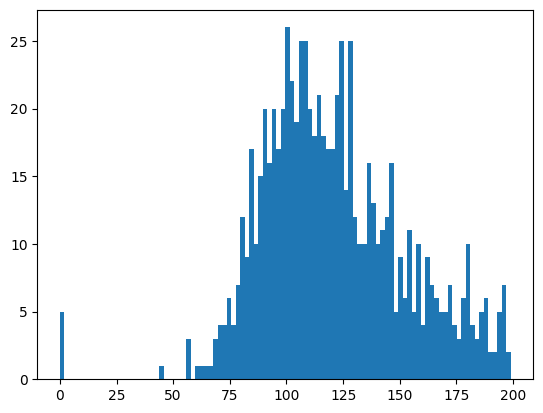

In [8]:
plt.hist(diabetes_data['Glucose'], bins=100)

Glucose 피처의 히스토그램을 확인해 보면 0값이 일정 수준 존재하는 것을 알 수 있음.

<h4>[min값이 0으로 되어 있는 피처에 대해 0값의 건수 및 전체 데이터 건수 대비 몇 퍼센트의 비율로 존재하는지 확인]</h4>

In [9]:
# 0값을 검사할 피처명 리스트 객체 설정
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복 하면서 데이터 값이 0 인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


출력 결과 SkinThickness와 Insulin의 0값이 상당히 많다는 것을 알 수 있음. 
<br>전체 데이터 수가 많지 않기 때문에 이 데이터를 다 삭제하면 학습을 효과적으로 수행하기 어려움.
<br>따라서 위 피처의 0값을 평균값으로 대체함.

<h4>[0값을 평균값으로 대체]</h4>

In [10]:
# zero_features 리스트 내부에 저장된 개별 피처들에 대해서 0값을 평균 값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

<h4>[0값을 평균값으로 대체한 데이터 세트에 피처 스케일링을 적용해 변환 후 로지스틱 회귀 적용]</h4>

In [11]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler( )
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행. 
lr_clf = LogisticRegression()
lr_clf.fit(X_train , y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test , pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


출력 결과 성능 수치가 일정 수준 개선된 것을 확인할 수 있음.
<br>하지만, 아직 재현율 수치의 개선이 필요함.
<br>따라서 분류 결정 임곘값을 변화시키면서 확인해 봄.

<h4>[분류 결정 임곗값 변화에 따른 평가 지표 변화 확인]</h4>

In [13]:
thresholds = [0.3 , 0.33 ,0.36,0.39, 0.42 , 0.45 ,0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds )

임곗값: 0.3
오차 행렬
[[67 33]
 [11 43]]
정확도: 0.7143, 정밀도: 0.5658, 재현율: 0.7963,    F1: 0.6615, AUC:0.8433
임곗값: 0.33
오차 행렬
[[72 28]
 [12 42]]
정확도: 0.7403, 정밀도: 0.6000, 재현율: 0.7778,    F1: 0.6774, AUC:0.8433
임곗값: 0.36
오차 행렬
[[76 24]
 [15 39]]
정확도: 0.7468, 정밀도: 0.6190, 재현율: 0.7222,    F1: 0.6667, AUC:0.8433
임곗값: 0.39
오차 행렬
[[78 22]
 [16 38]]
정확도: 0.7532, 정밀도: 0.6333, 재현율: 0.7037,    F1: 0.6667, AUC:0.8433
임곗값: 0.42
오차 행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667,    F1: 0.6792, AUC:0.8433
임곗값: 0.45
오차 행렬
[[85 15]
 [18 36]]
정확도: 0.7857, 정밀도: 0.7059, 재현율: 0.6667,    F1: 0.6857, AUC:0.8433
임곗값: 0.48
오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433
임곗값: 0.5
오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111,    F1: 0.6804, AUC:0.8433


책이랑 약간 출력결과가 다른데 책에서는 임곗값 0.48이 전체적인 성능 평가 지표를 유지하며 재현율을 약간 향상시키는 좋은 임곗값으로 선택함.

<h4>[임곗값을 0.48로 낮춘 상태에서 다시 예측]</h4>

predict() 메서드는 임곗값을 마음대로 변환할 수 없으므로 Binarizer 클래스를 이용해 predict_proba()로 추출한 예측 결과 확률 값을 변환하여 구함.

In [14]:
# 임곗값를 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 컬럼값을 Binarizer변환. 
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1)) 

get_clf_eval(y_test , pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481,    F1: 0.6931, AUC:0.8433
